# Obesity Dataset Analysis

Bu notebook, obezite veri seti üzerinde 3 farklı analiz gerçekleştirmektedir:
1. **Classification** - Obezite seviyelerinin sınıflandırılması
2. **Regression** - BMI tahmin modeli
3. **Clustering** - Kümeleme analizi

---
## 1. Classification (Sınıflandırma)

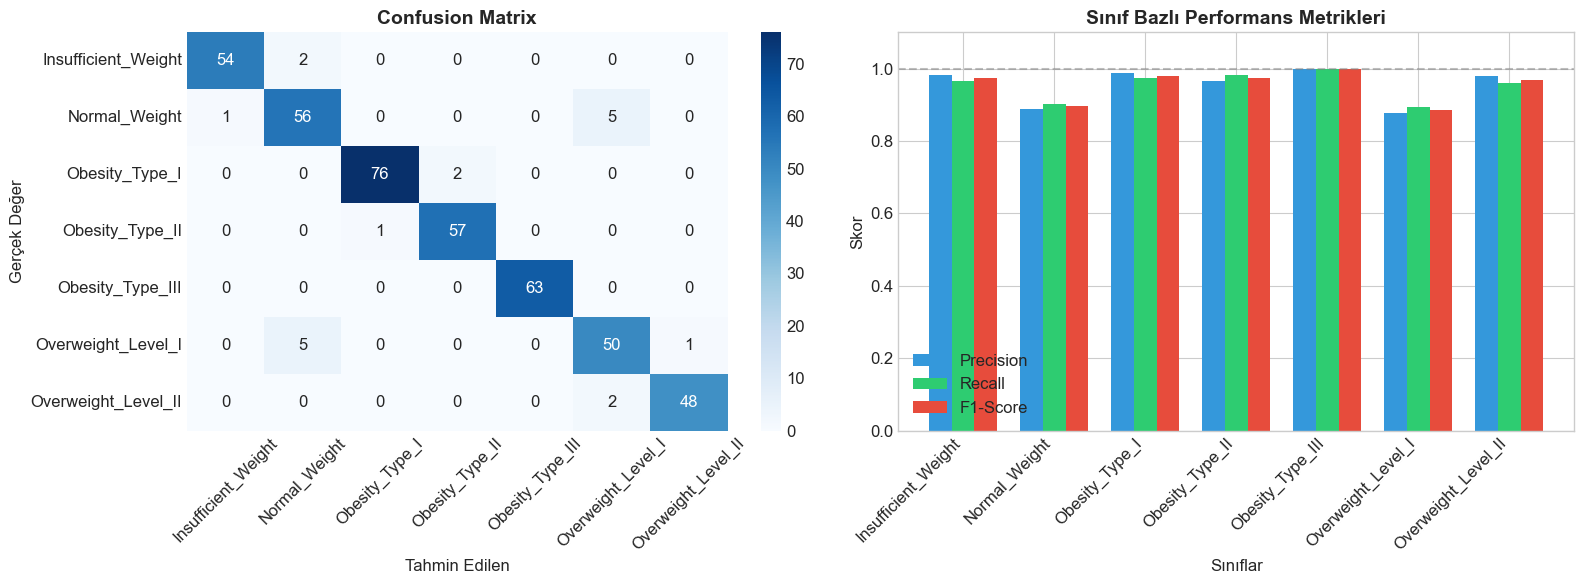

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


def run_classification(csv_path: str) -> None:
    df_raw = pd.read_csv(csv_path)
    df = df_raw.copy()

    categorical_cols = [
        "Gender", "family_history_with_overweight", "FAVC", "CAEC",
        "SMOKE", "SCC", "CALC", "MTRANS"
    ]

    # Encode categorical columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Encode target
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(df["NObeyesdad"])
    class_names = target_encoder.classes_

    X = df.drop("NObeyesdad", axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    report = classification_report(
        y_test, y_pred, target_names=class_names, output_dict=True
    )

    precision_scores = [report[c]["precision"] for c in class_names]
    recall_scores = [report[c]["recall"] for c in class_names]
    f1_scores = [report[c]["f1-score"] for c in class_names]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Confusion Matrix
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names, ax=axes[0]
    )
    axes[0].set_title("Confusion Matrix", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Tahmin Edilen", fontsize=12)
    axes[0].set_ylabel("Gerçek Değer", fontsize=12)
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].tick_params(axis="y", rotation=0)

    # Class metrics bar chart
    x = np.arange(len(class_names))
    width = 0.25

    axes[1].bar(x - width, precision_scores, width, label="Precision", color="#3498db")
    axes[1].bar(x, recall_scores, width, label="Recall", color="#2ecc71")
    axes[1].bar(x + width, f1_scores, width, label="F1-Score", color="#e74c3c")

    axes[1].set_xlabel("Sınıflar", fontsize=12)
    axes[1].set_ylabel("Skor", fontsize=12)
    axes[1].set_title("Sınıf Bazlı Performans Metrikleri", fontsize=14, fontweight="bold")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(class_names, rotation=45, ha="right")
    axes[1].legend()
    axes[1].set_ylim(0, 1.1)
    axes[1].axhline(y=1.0, color="gray", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.savefig("confusion_matrix_ve_metrikler.png", dpi=150, bbox_inches="tight")
    plt.show()


# Çalıştır
run_classification("ObesityDataSet.csv")

---
## 2. Regression (Regresyon)

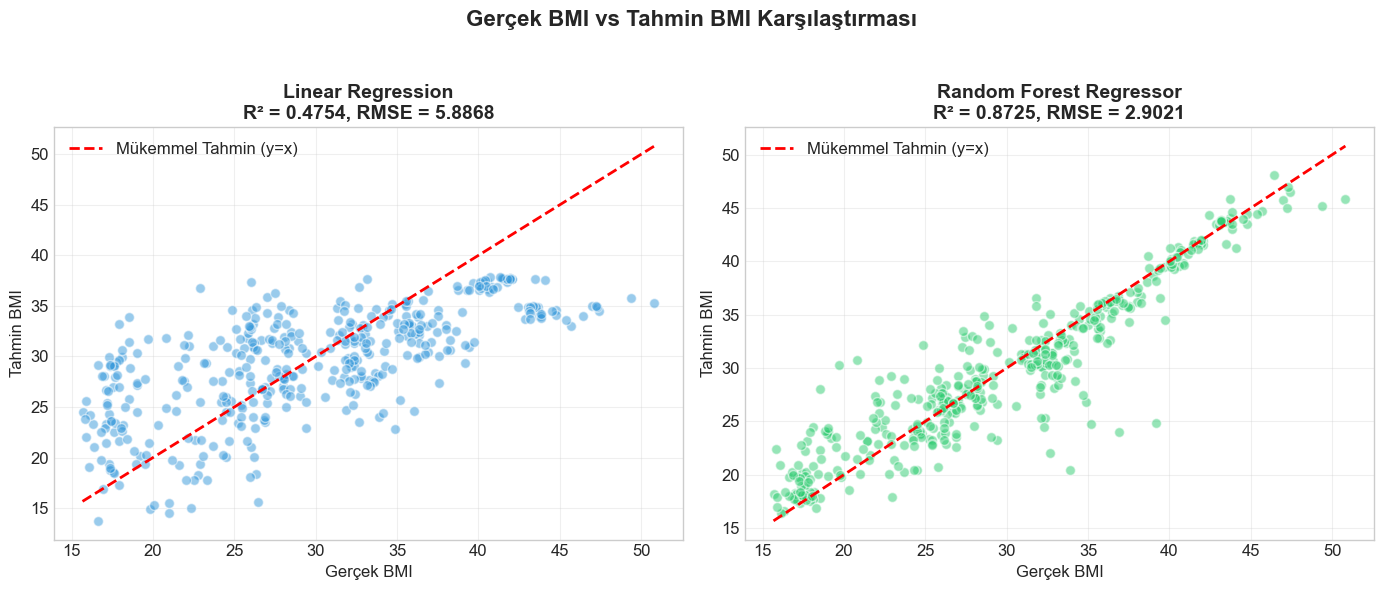

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def run_regression(csv_path: str) -> None:
    df = pd.read_csv(csv_path)

    # BMI
    df["BMI"] = df["Weight"] / (df["Height"] ** 2)

    categorical_cols = [
        "Gender", "family_history_with_overweight", "FAVC", "CAEC",
        "SMOKE", "SCC", "CALC", "MTRANS"
    ]

    # Encode categorical
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Avoid leakage: drop BMI target, label, and Weight/Height used in BMI formula
    X_reg = df.drop(["BMI", "NObeyesdad", "Weight", "Height"], axis=1)
    y_reg = df["BMI"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    lr_mae = mean_absolute_error(y_test, y_pred_lr)
    lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    lr_r2 = r2_score(y_test, y_pred_lr)

    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    rf_mae = mean_absolute_error(y_test, y_pred_rf)
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rf_r2 = r2_score(y_test, y_pred_rf)

    # Plot: True vs Predicted
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(y_test, y_pred_lr, alpha=0.5, color="#3498db", edgecolors="white", s=50)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 "r--", lw=2, label="Mükemmel Tahmin (y=x)")
    axes[0].set_xlabel("Gerçek BMI", fontsize=12)
    axes[0].set_ylabel("Tahmin BMI", fontsize=12)
    axes[0].set_title(f"Linear Regression\nR² = {lr_r2:.4f}, RMSE = {lr_rmse:.4f}",
                      fontsize=14, fontweight="bold")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(y_test, y_pred_rf, alpha=0.5, color="#2ecc71", edgecolors="white", s=50)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 "r--", lw=2, label="Mükemmel Tahmin (y=x)")
    axes[1].set_xlabel("Gerçek BMI", fontsize=12)
    axes[1].set_ylabel("Tahmin BMI", fontsize=12)
    axes[1].set_title(f"Random Forest Regressor\nR² = {rf_r2:.4f}, RMSE = {rf_rmse:.4f}",
                      fontsize=14, fontweight="bold")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("Gerçek BMI vs Tahmin BMI Karşılaştırması", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("bmi_regression_sonuclari.png", dpi=150, bbox_inches="tight")
    plt.show()


# Çalıştır
run_regression("ObesityDataSet.csv")

---
## 3. Clustering (Kümeleme)

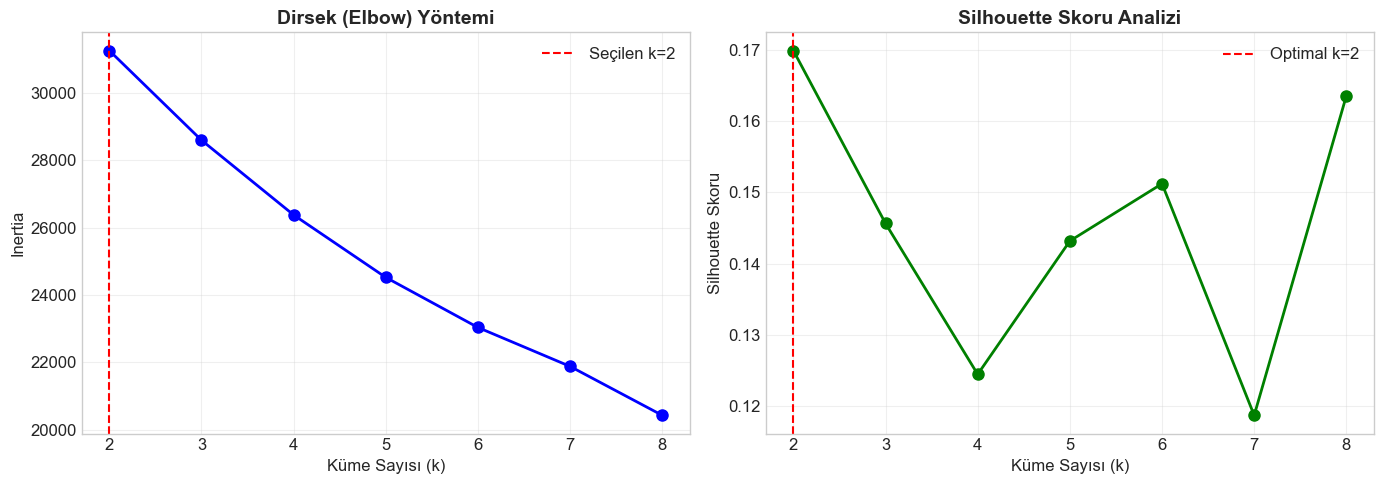

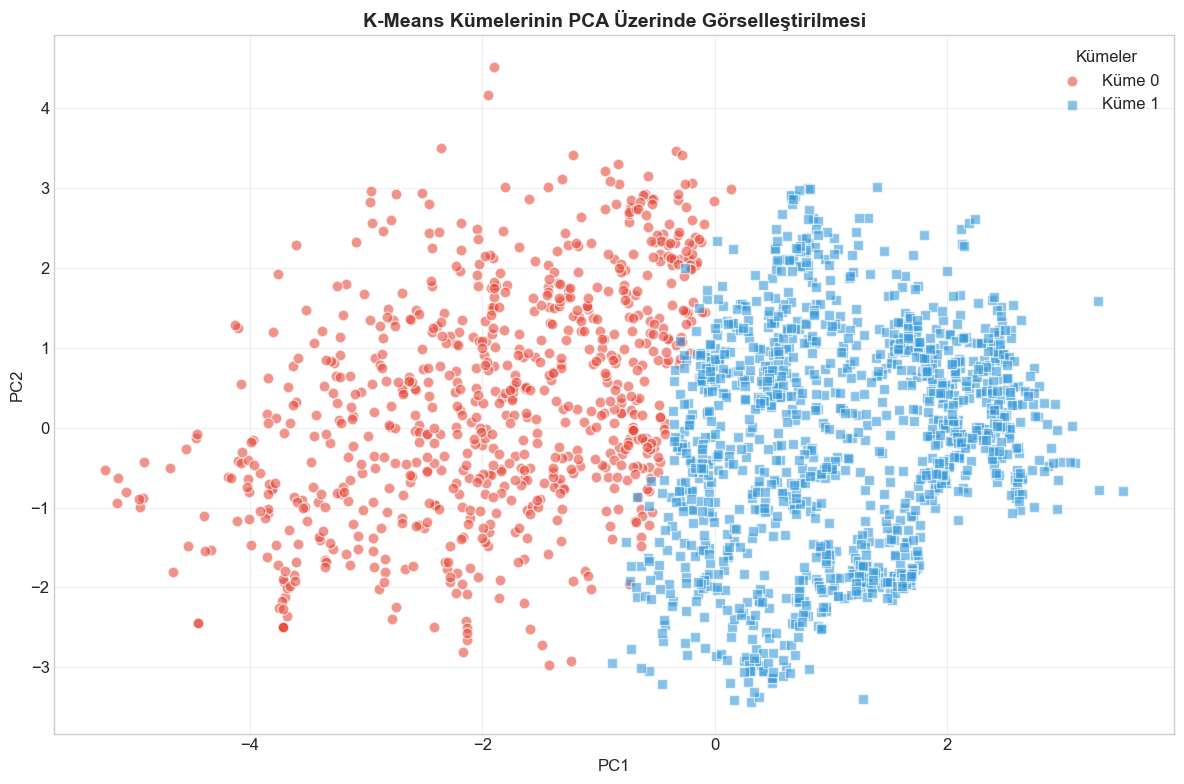

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


def run_clustering(csv_path: str) -> None:
    df = pd.read_csv(csv_path)

    # BMI
    df["BMI"] = df["Weight"] / (df["Height"] ** 2)

    categorical_cols = [
        "Gender", "family_history_with_overweight", "FAVC", "CAEC",
        "SMOKE", "SCC", "CALC", "MTRANS"
    ]

    # Encode categorical
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    cluster_features = [
        "Age", "Height", "Weight", "BMI", "Gender",
        "family_history_with_overweight", "FAVC", "FCVC", "NCP",
        "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"
    ]

    X_cluster = df[cluster_features]
    X_scaled = StandardScaler().fit_transform(X_cluster)

    # Elbow + Silhouette
    k_range = range(2, 9)
    inertias = []
    silhouettes = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X_scaled, km.labels_))

    best_k = list(k_range)[int(np.argmax(silhouettes))]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(list(k_range), inertias, "bo-", linewidth=2, markersize=8)
    axes[0].set_xlabel("Küme Sayısı (k)", fontsize=12)
    axes[0].set_ylabel("Inertia", fontsize=12)
    axes[0].set_title("Dirsek (Elbow) Yöntemi", fontsize=14, fontweight="bold")
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=best_k, color="r", linestyle="--", label=f"Seçilen k={best_k}")
    axes[0].legend()

    axes[1].plot(list(k_range), silhouettes, "go-", linewidth=2, markersize=8)
    axes[1].set_xlabel("Küme Sayısı (k)", fontsize=12)
    axes[1].set_ylabel("Silhouette Skoru", fontsize=12)
    axes[1].set_title("Silhouette Skoru Analizi", fontsize=14, fontweight="bold")
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=best_k, color="r", linestyle="--", label=f"Optimal k={best_k}")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("kmeans_elbow_silhouette.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Final KMeans
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df["Cluster_Label"] = kmeans_final.fit_predict(X_scaled)

    # PCA 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    df["PC1"] = X_pca[:, 0]
    df["PC2"] = X_pca[:, 1]

    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ["#e74c3c", "#3498db", "#2ecc71", "#9b59b6", "#f39c12", "#1abc9c", "#e91e63", "#00bcd4"]
    markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

    for i in range(best_k):
        mask = df["Cluster_Label"] == i
        ax.scatter(
            df.loc[mask, "PC1"],
            df.loc[mask, "PC2"],
            c=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            label=f"Küme {i}",
            alpha=0.6,
            s=60,
            edgecolors="white"
        )

    ax.set_xlabel("PC1", fontsize=12)
    ax.set_ylabel("PC2", fontsize=12)
    ax.set_title("K-Means Kümelerinin PCA Üzerinde Görselleştirilmesi", fontsize=14, fontweight="bold")
    ax.legend(title="Kümeler", loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("kmeans_pca_visualization.png", dpi=150, bbox_inches="tight")
    plt.show()


# Çalıştır
run_clustering("ObesityDataSet.csv")